In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns     # you can install this with "pip install seaborn"
import sys
import pprint, math
from process_logs import *  # various functions used to process experiment log file
%matplotlib inline  
#print(plt.rcParams.keys())
params = {'font.size': 18, 'figure.titlesize':'medium','legend.fontsize': 'medium','legend.handlelength':2,
          'lines.linewidth':2, 'lines.markersize':10, 'legend.handletextpad':0,}
plt.rcParams.update(params)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Settings
Edit the variables below to indicate which plots to generate, the algs list is a list of subdirectories with results (they must contain the file parsed-power-aggregate.txt.

In [2]:
algs = ['MST/output-16epv','MST/output-8epv','MST/output-real','CC/output-16epv','CC/output-8epv','CC/output-real']
algs = ['MST/output-8epv-new','MST/output-real-new']
#algs = ['CC/output-8epv','CC/output-real']
whats = {'Energy':'Total CPU Energy (J)','Power':'Average CPU Power (W)', 'Memory':'Total Memory (GB)','Time':'Time (seconds)'}
#whats = {'Power':'Average CPU Power (W)'}
epvs = ['8']
nws = ['ER','G']
#nws = ['com-lj-org-weighted','soc-pokec','youtubeNetwork']
insperc = ['100','75']

## Functions
A couple of functions that extract the data and generate the plots.

In [7]:
def genBoxPlot(alg, what, ddf, network):
    # df should be for a single network
    global whats
    print(alg,what,network)
    if ddf.empty: 
        print(': No data'); 
        return
     
    df=ddf[ddf['what'].str.contains(what)].copy()
    #print(df.head(100))
    df['what'].replace(what,whats[what])
    df.sort_values(by=['Threads'],inplace=True)
    
    # Check if there is any deletion (<100% insertion)
    parts = network.split('_')
    if parts[2].startswith('100'): nodeletion = True
    else: nodeletion = False

    # Figure settings
    fig, ax = plt.subplots()
    fig.set_size_inches(8,8)
    sns.set_style("whitegrid")   
    legend_columns = 1; legend_placement = 'upper right'
    if what == 'Power': legend_placement = 'upper left'
    all_colors = {alg+'-ins-p0' : '#0443cc', alg+'-ins-p1' : '#4982ff', 
                alg+'-del-p0' : '#4500bc', alg+'-del-p1' : '#8037fc',
                'Galois-p0' : '#af0000', 'Galois-p1' : '#ff3a3a',
                alg+'-Memory' : '#0443cc', 'Galois-Memory' : '#af0000',
                'Baseline' : "#f6ff0a"}
    if what != "Memory":
        palette="Paired"
        if what == "Time":
            value_vars = [alg+'-ins-p0']
            if not nodeletion: value_vars += [alg + '-del-p0']
            value_vars += ['Galois-p0']
            new_labels=[alg+'-ins',alg+'-del','Galois']
            legend_placement = 'center right'
        else: 
            value_vars = [alg+'-ins-p0',alg+'-ins-p1']
            if not nodeletion: 
                value_vars += [alg + '-del-p0', alg+'-del-p1']
            value_vars += ['Galois-p0','Galois-p1']
            new_labels = value_vars
    else:
        value_vars = [alg+'-Memory','Galois-Memory']
        new_labels = value_vars
        legend_placement = 'center left'

    if what == "Power": value_vars.append("Baseline")
        
    # Done setting value_vars, now create colormap
    #print(all_colors,value_vars)
    colors = [all_colors[x] for x in value_vars]
    
    dd=pd.melt(df, id_vars=['Threads'], value_vars=value_vars, var_name='Operation')
   
    #ax = sns.barplot(ax=ax,x='Threads',y='value',data=dd,hue='Operation',palette="Set3")
    sns.set_palette(sns.color_palette(colors))
    if what in ["Time","Memory"]:
        g = sns.pointplot(x='Threads',y='value',data=dd,hue='Operation', ax=ax, legend=False,
                          markers=["^","*",'.',"1"], linestyles=["-", "--", ":",'-.']) 
    else:
        #sns.boxplot(x='Threads',y='value',data=dd,hue='Operation', ax=ax) 
        g = sns.pointplot(x='Threads',y='value',data=dd,hue='Operation', ci=None, ax=ax, legend=False, 
                      markers=['^', '1','*','o','x','+','.'], linestyles=["-", "--", ":",'-.','-',':','--'])
    sns.despine(offset=10, trim=True)
    
    
    # Legend
    handles, labels = ax.get_legend_handles_labels()
    #if len(value_vars) <=4: legend_columns = len(value_vars)
    plt.legend(handles, labels, loc=legend_placement, frameon=True, framealpha=0.8, 
               ncol=legend_columns, columnspacing=0)

    #plt.subplots_adjust(top=.925)
    
    # Axes
    ymin,ymax = ax.get_ylim()
    if ymax > 100 and what != 'Memory': ymax=1.1 * ymax
    ax.set(xlim=(0, None),ylim=(ymin,ymax))
    plt.xlabel("Number of Threads")
    plt.ylabel(whats[what])

    filename = alg.upper() + "_" + network + "_" + what + '.pdf'
    title = network + ": " +whats[what]
    plt.title(title)
    plt.savefig(filename)
    plt.show()

## Driver for generating all the plots
All the data structures are populated by extractData and plots are generated with genBoxPlot

MST Time 248_G_75i_1000000


/Applications/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


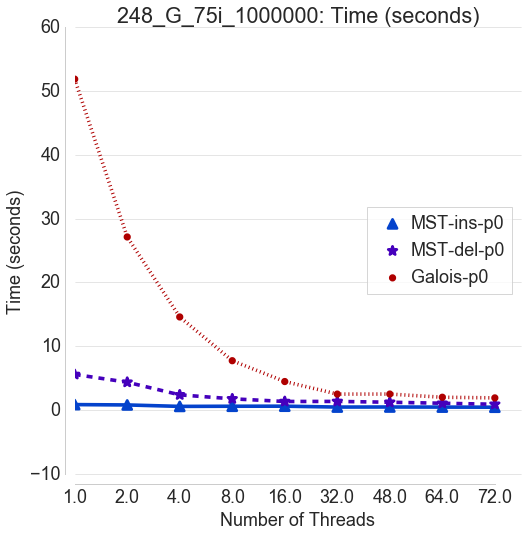

MST Time 248_G_100i_1000000


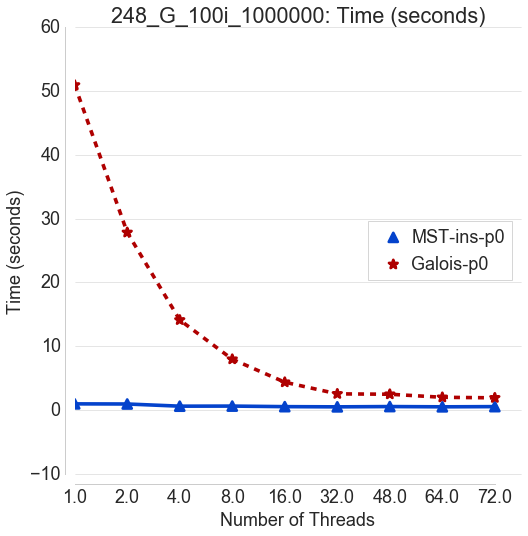

MST Time 248_ER_100i_1000000


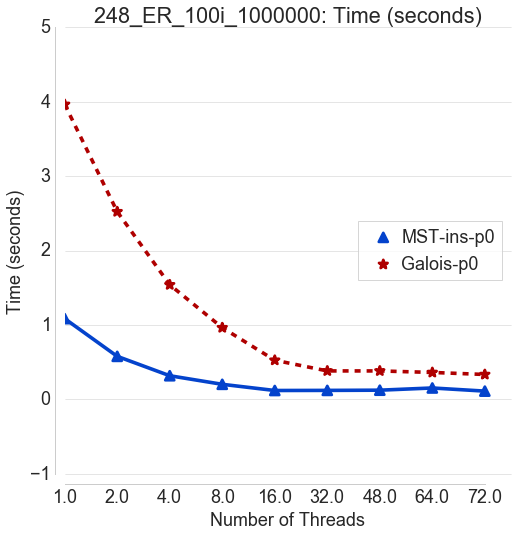

MST Time 248_ER_75i_1000000


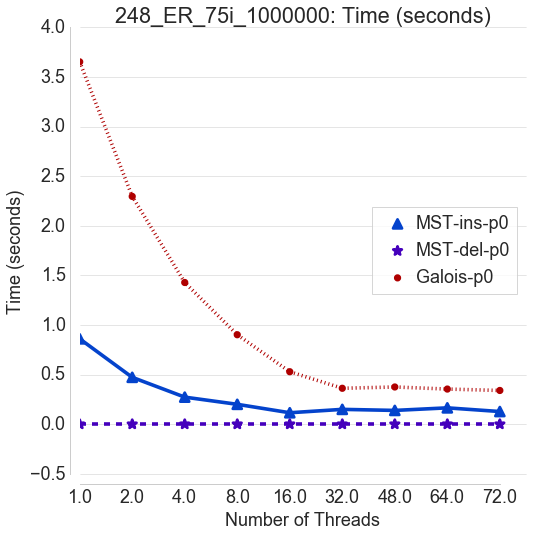

MST Energy 248_G_75i_1000000


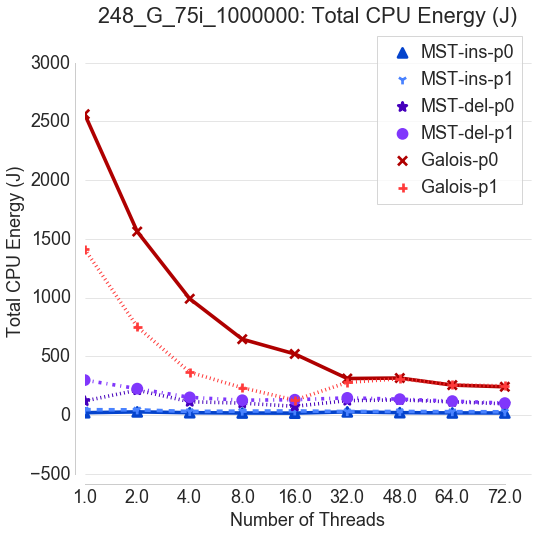

MST Energy 248_G_100i_1000000


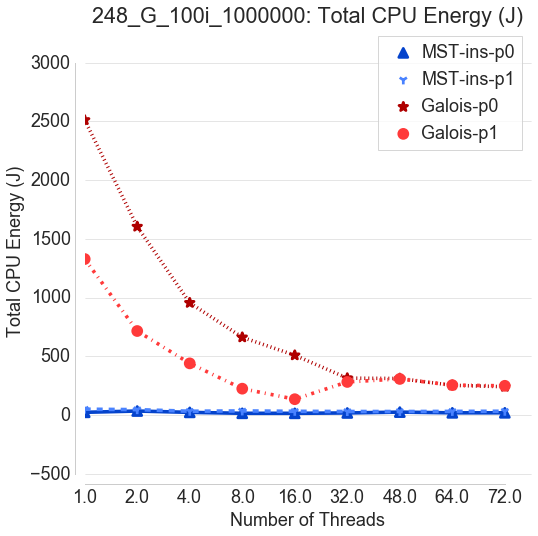

MST Energy 248_ER_100i_1000000


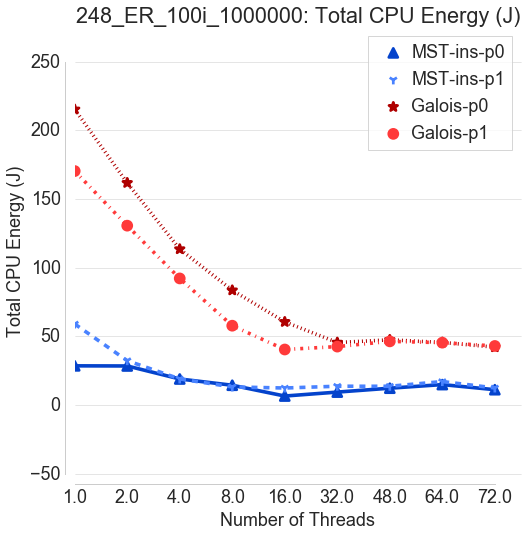

MST Energy 248_ER_75i_1000000


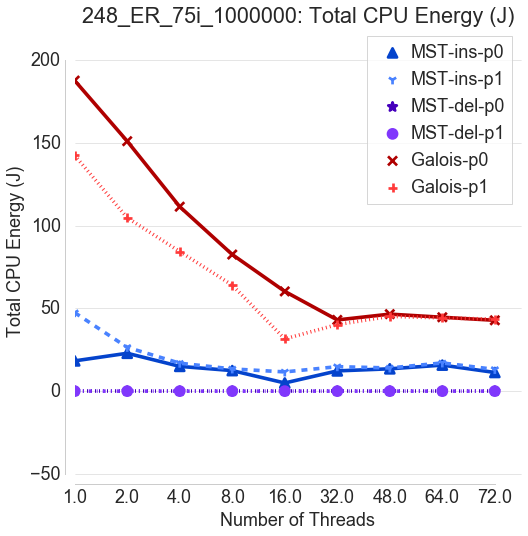

MST Memory 248_G_75i_1000000


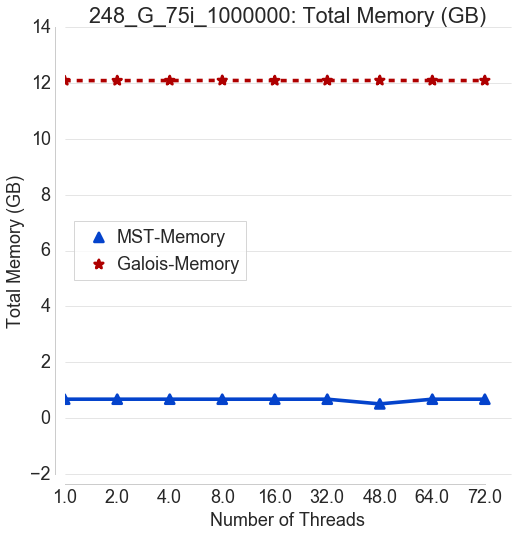

MST Memory 248_G_100i_1000000


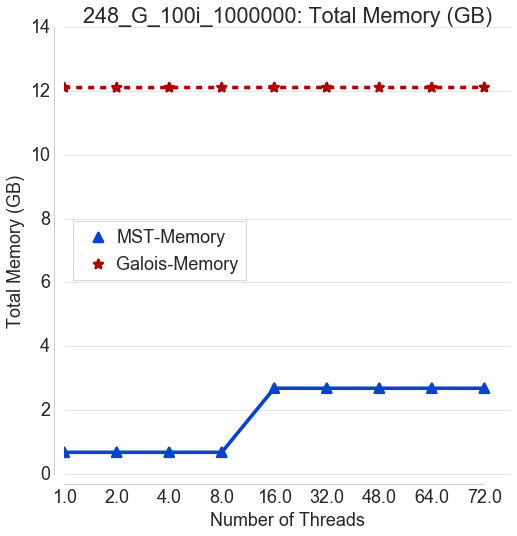

MST Memory 248_ER_100i_1000000


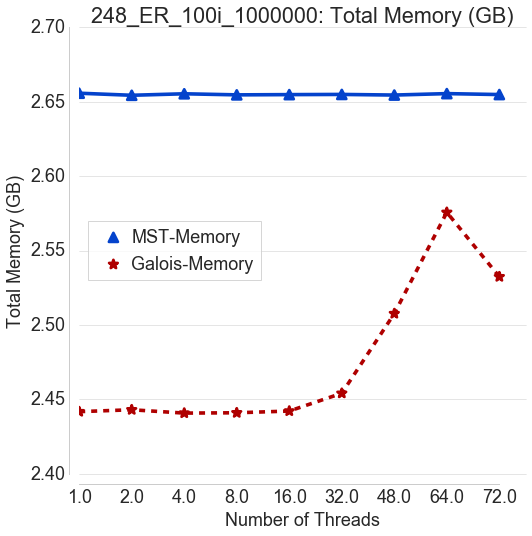

MST Memory 248_ER_75i_1000000


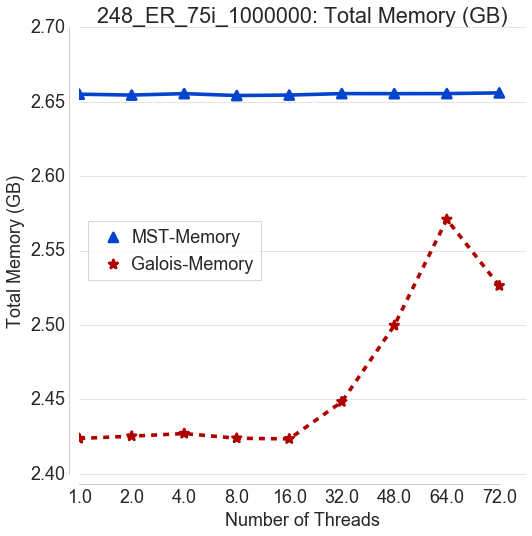

MST Power 248_G_75i_1000000


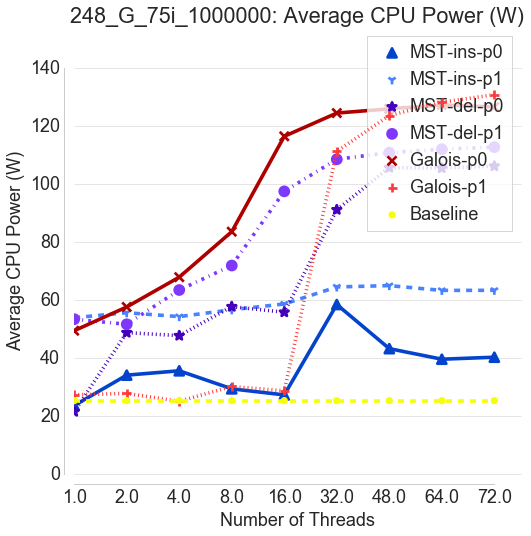

MST Power 248_G_100i_1000000


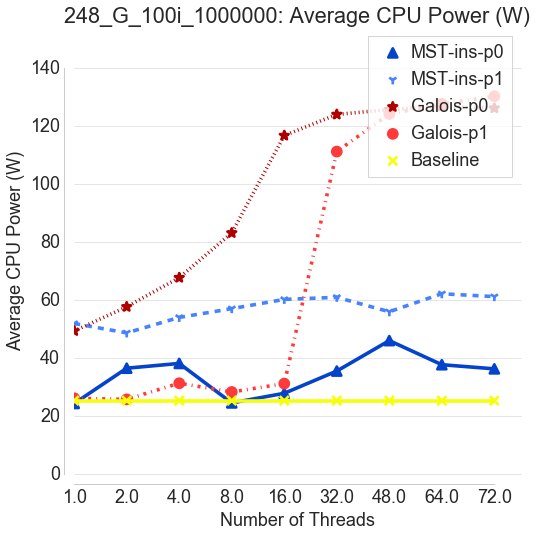

MST Power 248_ER_100i_1000000


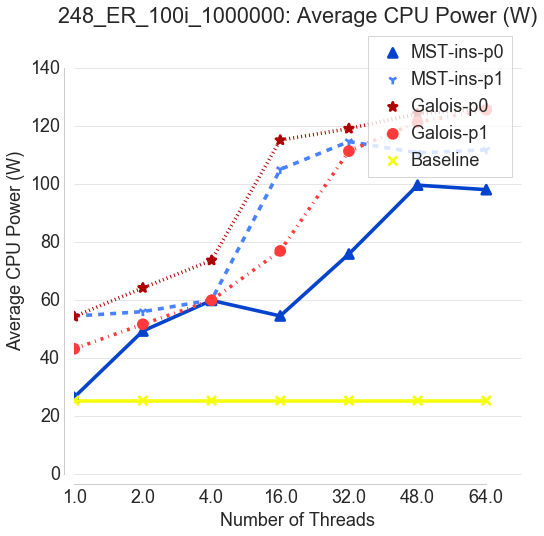

MST Power 248_ER_75i_1000000


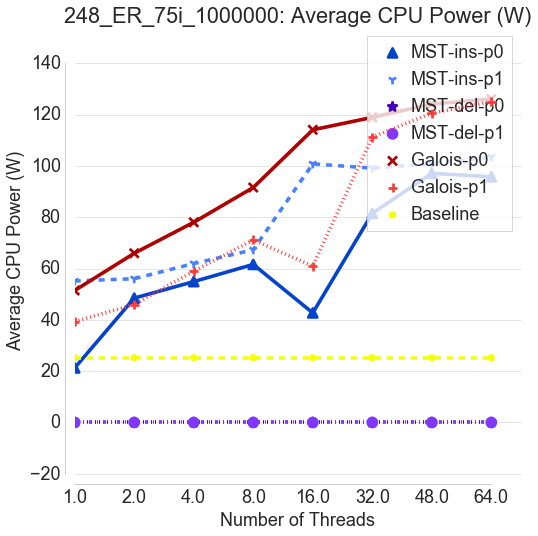

MST Time youtubeNetwork_100i_1000000


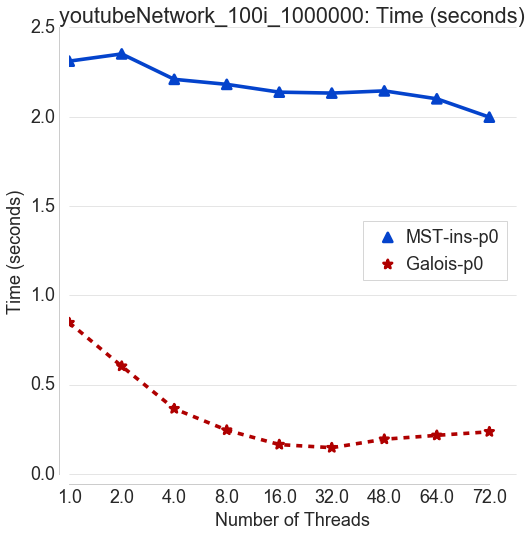

MST Time com-lj-org-weighted_75i_1000000


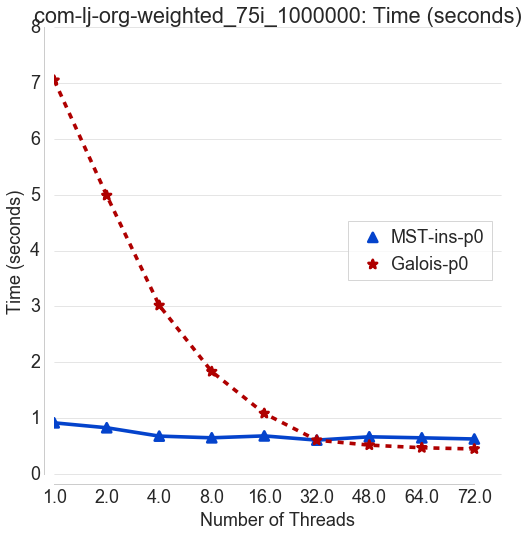

MST Time youtubeNetwork_75i_1000000


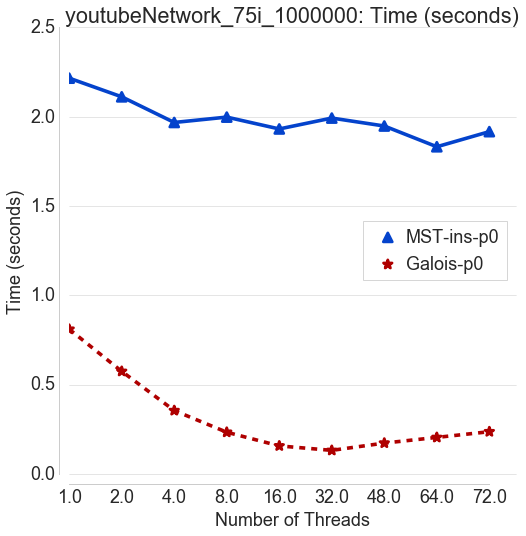

MST Time soc-pokec_75i_1000000


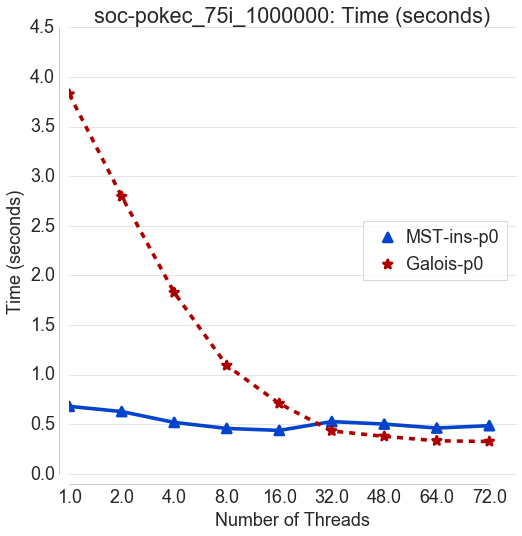

MST Time com-lj-org-weighted_100i_1000000


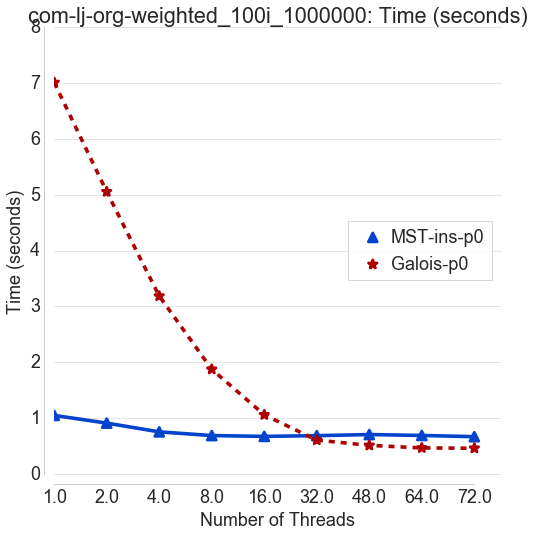

MST Time soc-pokec_100i_1000000


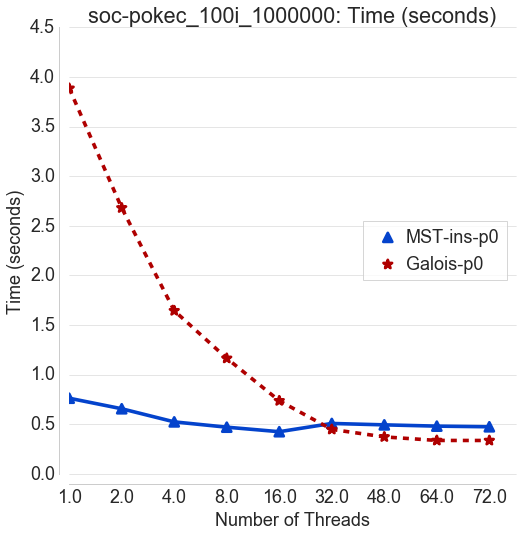

MST Energy youtubeNetwork_100i_1000000


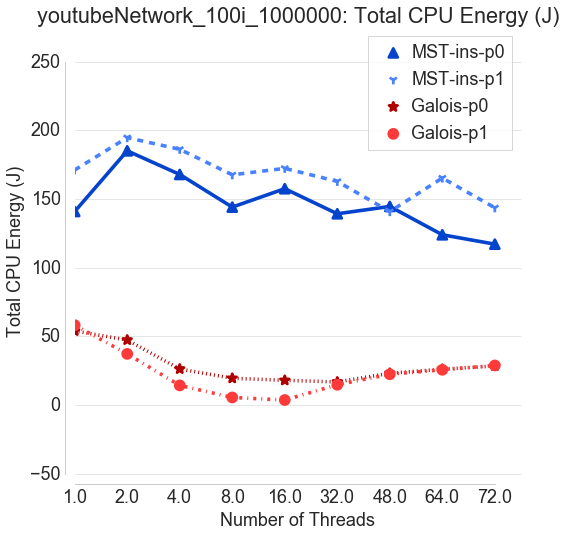

MST Energy com-lj-org-weighted_75i_1000000


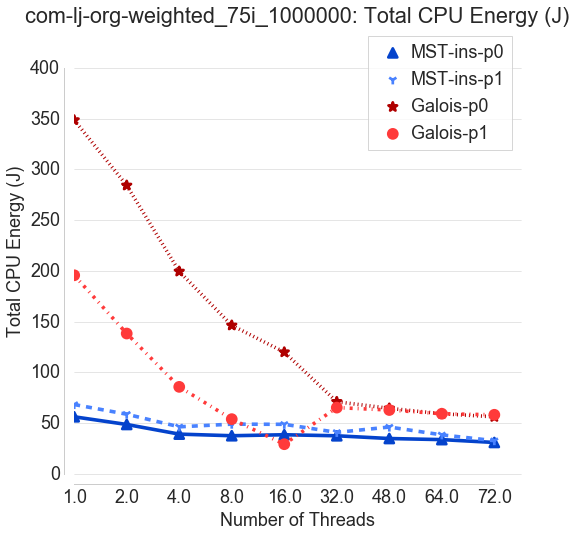

MST Energy youtubeNetwork_75i_1000000


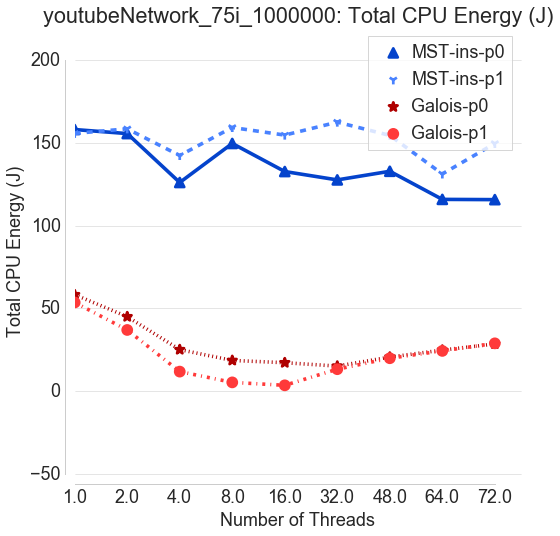

MST Energy soc-pokec_75i_1000000


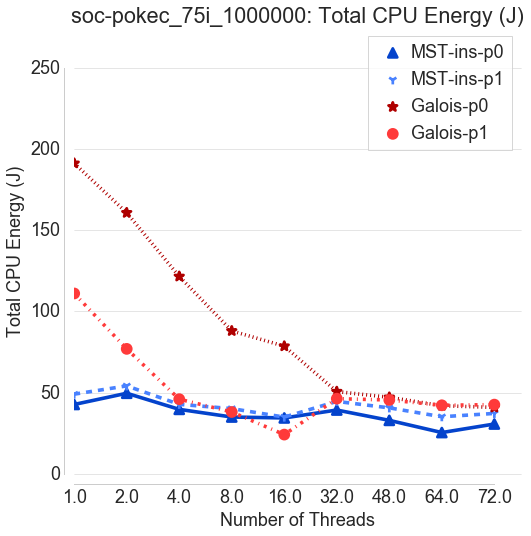

MST Energy com-lj-org-weighted_100i_1000000


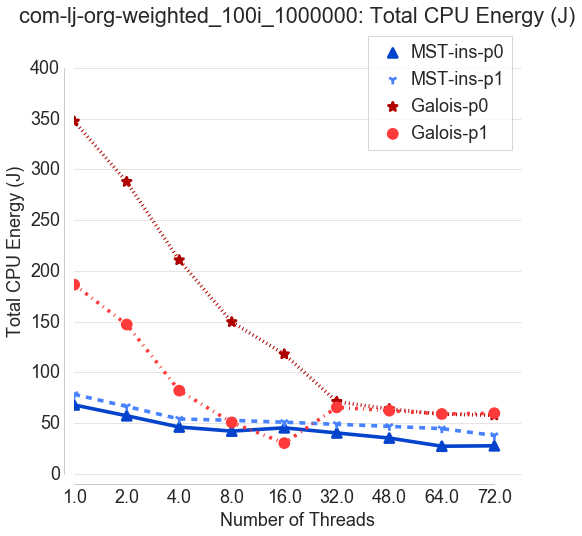

MST Energy soc-pokec_100i_1000000


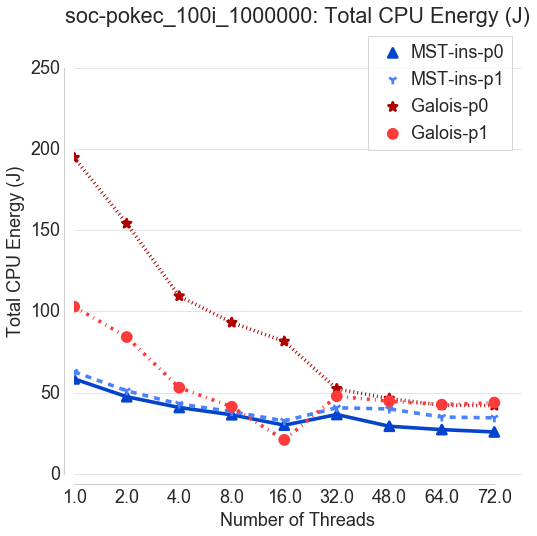

MST Memory youtubeNetwork_100i_1000000


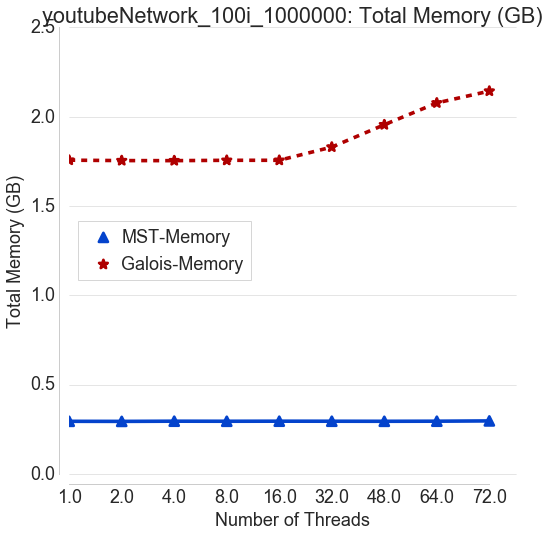

MST Memory com-lj-org-weighted_75i_1000000


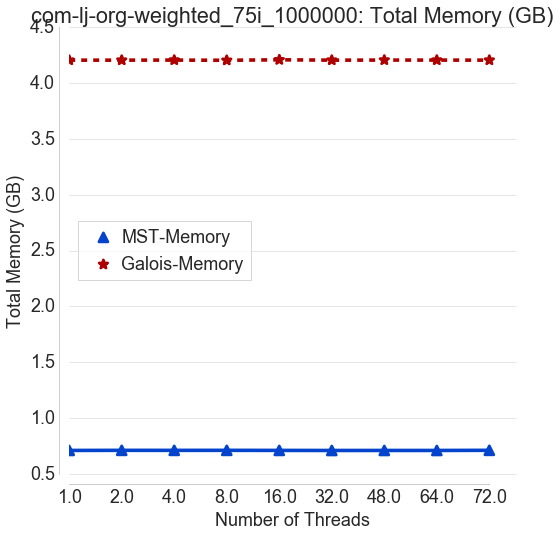

MST Memory youtubeNetwork_75i_1000000


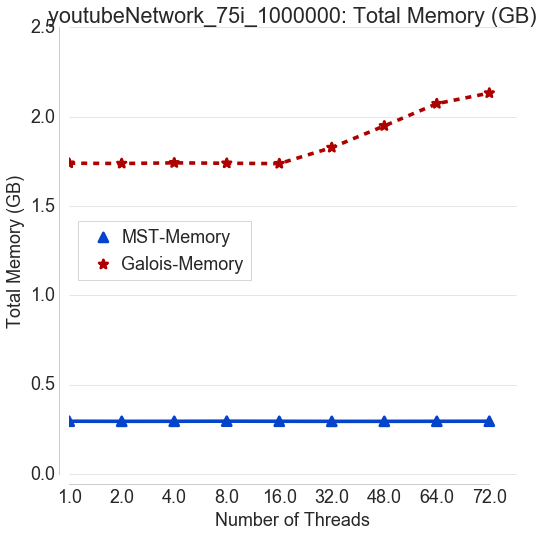

MST Memory soc-pokec_75i_1000000


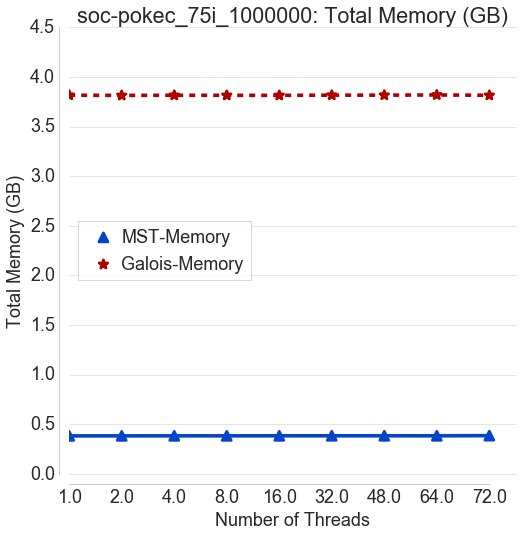

MST Memory com-lj-org-weighted_100i_1000000


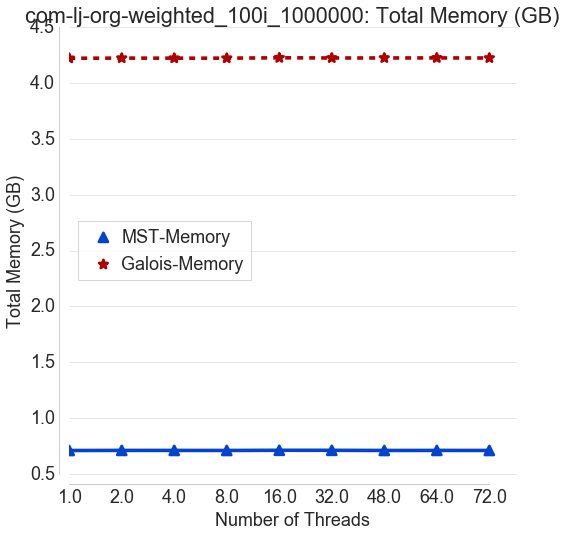

MST Memory soc-pokec_100i_1000000


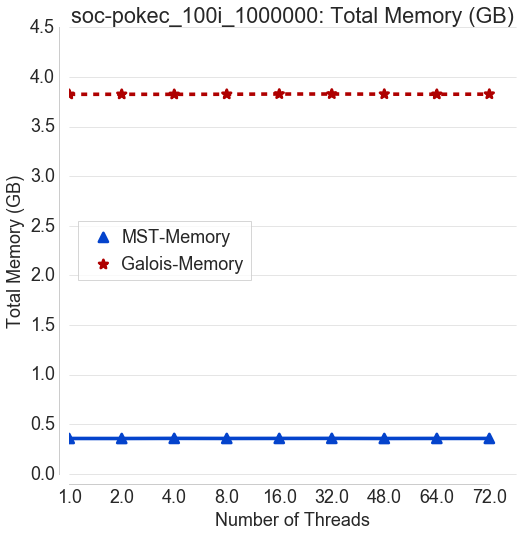

MST Power youtubeNetwork_100i_1000000


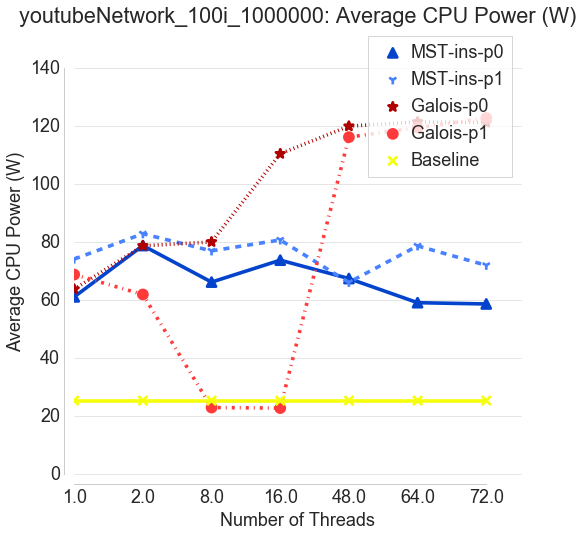

MST Power com-lj-org-weighted_75i_1000000


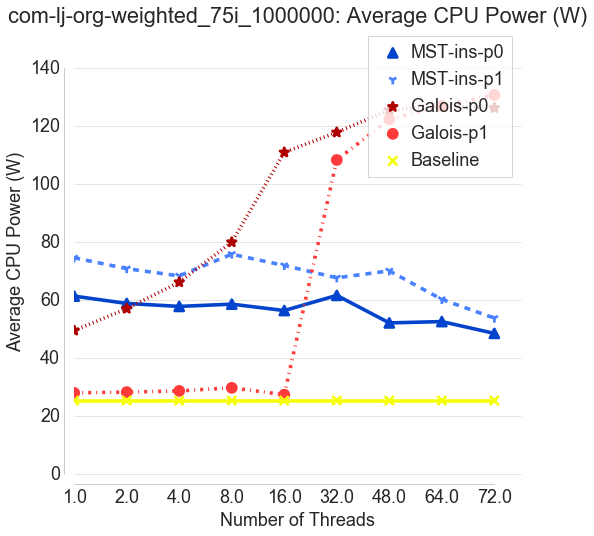

MST Power youtubeNetwork_75i_1000000


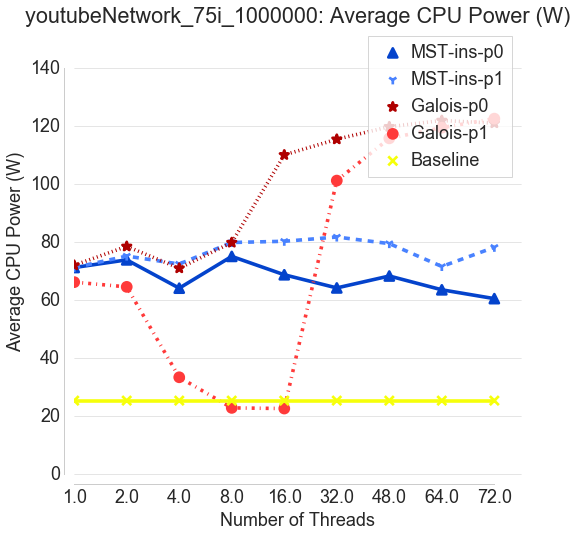

MST Power soc-pokec_75i_1000000


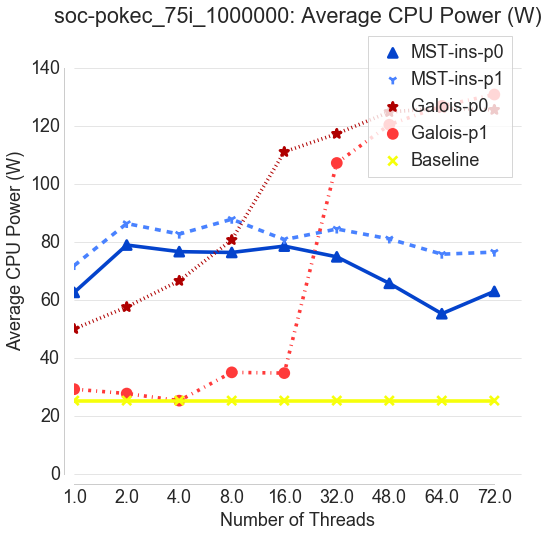

MST Power com-lj-org-weighted_100i_1000000


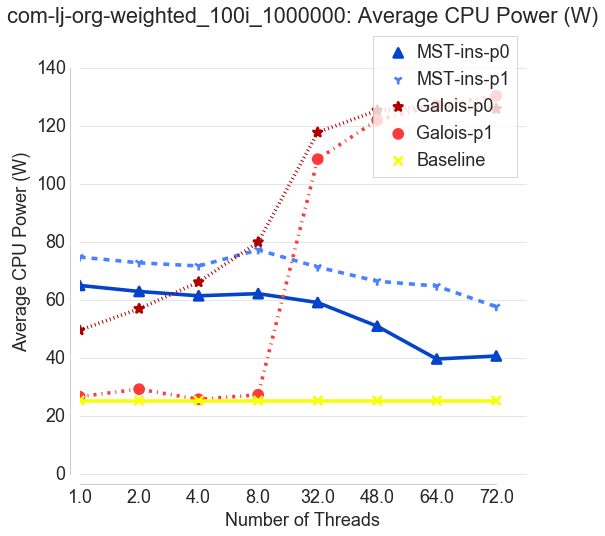

MST Power soc-pokec_100i_1000000


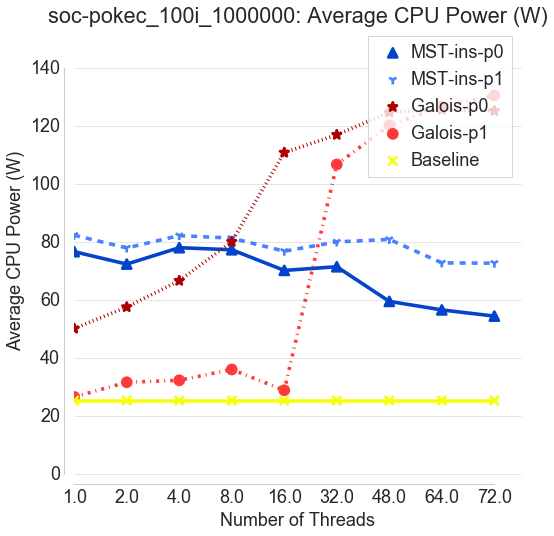

In [8]:
algnames = [x.split('/')[0] for x in algs]
pp = pprint.PrettyPrinter(indent=2)

for algfull in algs:
    alg = algfull.split('/')[0]
    networks = processLogs(algfull)
    allnets = []
    summaries = []
    columns = ["what","Network", "Threads", alg+"-ins-p0", alg+"-ins-p1", 
                alg+"-del-p0", alg+"-del-p1", 'Galois-p0','Galois-p1',
                alg + "-Memory","Galois-Memory","Baseline"]

    df = pd.DataFrame(columns = columns)
    for n in networks.values():
        #print(n)
        for what in whats.keys():
            summary = n.summarize(what)
            summaries.append(summary)
            threads= summary['Threads']
            network = '_'.join(summary['Experiment'].split('_')[:-1])
            if network not in allnets: allnets.append(network)
            
            vals = [what, network, int(threads), 
                    np.mean(summary['Insertion-pkg0']), np.mean(summary['Insertion-pkg1']), 
                    np.mean(summary['Deletion-pkg0']), np.mean(summary['Deletion-pkg1']), 
                    np.mean(summary['Galois-pkg0']), np.mean(summary['Galois-pkg1']), 
                    np.mean(summary['Memory']), np.mean(summary['Galois-mem'])]
            if what == "Power": vals.append(baseline_power)
            else: vals.append(float('NaN'))
               
            df2 = pd.DataFrame([ vals ], columns=columns)
            df = df.append(df2, ignore_index=True).fillna(0)
            for col in [alg+"-del-p1"]:
                #q = df[col].quantile(0.99)
                df = df[df[col] < 600]
                pass
            
    df.index.name='id'
    
    for what in whats.keys():
        for network in allnets: 
            currentdf = df[df['Network'].str.contains(network)]
            genBoxPlot(alg,what,currentdf,network)
